In [2]:
# Ignoring warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import torch
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler, random_split
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from tabulate import tabulate
from torch.cuda.amp import GradScaler, autocast
from collections import Counter

In [3]:
data_dir = r'F:/Umar/Final Dataset'
batch_size = 64
num_epochs = 30
learning_rate = 1e-4
num_classes = 30  # Update if different

# Define transformations with data augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load dataset
dataset = ImageFolder(root=data_dir, transform=transform)

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Calculate class weights
def calculate_class_weights(dataset):
    targets = [target for _, target in dataset]
    class_counts = Counter(targets)
    total_count = len(targets)
    class_weights = {cls: total_count / (len(class_counts) * count) for cls, count in class_counts.items()}
    weights = torch.tensor([class_weights[target] for _, target in dataset], dtype=torch.float)
    return weights

train_weights = calculate_class_weights(train_dataset)
val_weights = calculate_class_weights(val_dataset)

# Create DataLoaders with class balancing
train_sampler = WeightedRandomSampler(weights=train_weights, num_samples=len(train_weights), replacement=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

In [4]:
# Define the model
model = timm.create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Mixed Precision Training
scaler = GradScaler()

In [5]:
def compute_metrics(preds, targets):
    accuracy = accuracy_score(targets, preds)
    f1 = f1_score(targets, preds, average='weighted')
    return accuracy, f1

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
train_f1_scores, val_f1_scores = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss, train_corrects, train_preds, train_targets = 0.0, 0, [], []
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_corrects += torch.sum(preds == labels.data)
        train_preds.extend(preds.cpu().numpy())
        train_targets.extend(labels.cpu().numpy())

    # Compute training metrics
    train_loss = train_loss / len(train_loader.dataset)
    train_acc, train_f1 = compute_metrics(train_preds, train_targets)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    train_f1_scores.append(train_f1)

    model.eval()
    val_loss, val_corrects, val_preds, val_targets = 0.0, 0, [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)
            val_preds.extend(preds.cpu().numpy())
            val_targets.extend(labels.cpu().numpy())

    # Compute validation metrics
    val_loss = val_loss / len(val_loader.dataset)
    val_acc, val_f1 = compute_metrics(val_preds, val_targets)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_f1_scores.append(val_f1)

    # Print metrics
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print(f'Training Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, F1 Score: {train_f1:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, F1 Score: {val_f1:.4f}')

    # Print table
    table = [
        ["Epoch", "Train Loss", "Train Accuracy", "Train F1 Score", "Val Loss", "Val Accuracy", "Val F1 Score"],
        [epoch + 1, train_loss, train_acc, train_f1, val_loss, val_acc, val_f1]
    ]
    print(tabulate(table, headers="firstrow", tablefmt="grid"))

    # Update learning rate
    scheduler.step()

Epoch 1/30
Training Loss: 1.1819, Accuracy: 0.6196, F1 Score: 0.6152
Validation Loss: 0.9037, Accuracy: 0.6826, F1 Score: 0.6875
+---------+--------------+------------------+------------------+------------+----------------+----------------+
|   Epoch |   Train Loss |   Train Accuracy |   Train F1 Score |   Val Loss |   Val Accuracy |   Val F1 Score |
+=========+==============+==================+==================+============+================+================+
|       1 |      1.18191 |         0.619581 |         0.615163 |   0.903722 |        0.68259 |       0.687455 |
+---------+--------------+------------------+------------------+------------+----------------+----------------+
Epoch 2/30
Training Loss: 0.6125, Accuracy: 0.7784, F1 Score: 0.7748
Validation Loss: 0.6747, Accuracy: 0.7454, F1 Score: 0.7482
+---------+--------------+------------------+------------------+------------+----------------+----------------+
|   Epoch |   Train Loss |   Train Accuracy |   Train F1 Score |   Val

In [6]:
# Save the model
torch.save(model.state_dict(), 'swin_skin_disease_model.pth')

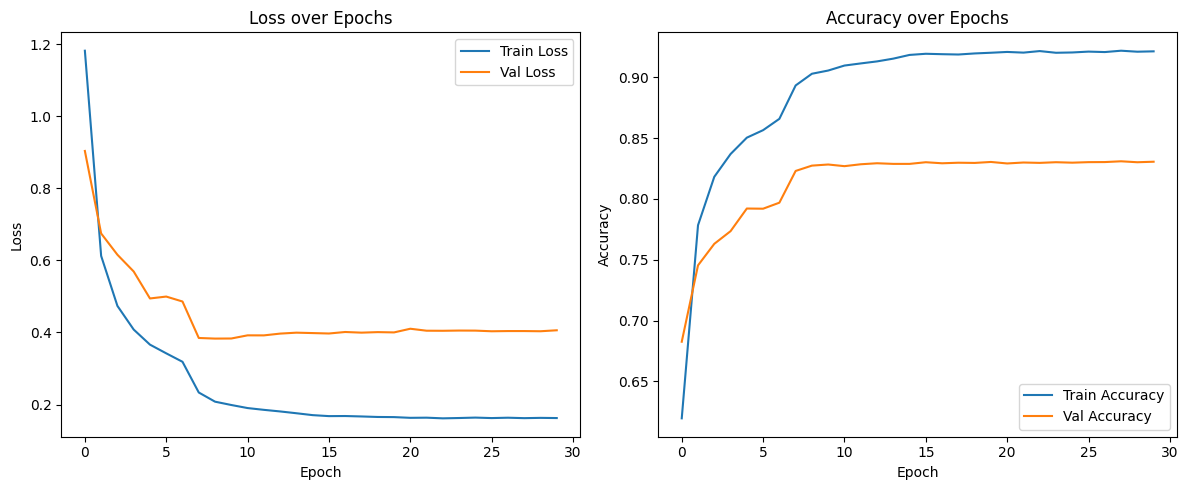

In [7]:
# Plot losses and accuracies
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.tight_layout()
plt.show()


Testing model

In [6]:
# Import necessary libraries
import torch
from torchvision import transforms
from PIL import Image
import timm

# Define the transformations (same as during training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the model
num_classes = 30  # This should be the same as used during training
model = timm.create_model('swin_base_patch4_window7_224', pretrained=False, num_classes=num_classes)
model.load_state_dict(torch.load('swin_skin_disease_model.pth'))
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Function to predict the class of an image
def predict_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
    
    return predicted.item()

# Example usage   
image_path = r'E:\Final Dataset\Hair Loss Photos Alopecia and other Hair Diseases\acne-keloidalis-21.jpg'  # Replace with the path to your image
predicted_class = predict_image(image_path)
print(f'Predicted class: {predicted_class}')

Predicted class: 10
